In [261]:
import numpy as np
import scipy as sp
import pandas as pd
import os
import seaborn as sns
import tabulate as tab
import dython as dt
from tabulate import tabulate
from pandas.plotting import scatter_matrix
from dython.nominal import associations


In [262]:
df = pd.read_csv('XY_train.csv',encoding='latin-1')
df.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,13163,city_16,0.910,NaN,No relevent experience,no_enrollment,High School,NaN,2,NaN,NaN,never,16,1
1,9357,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,6,1000-4999,Pvt Ltd,1,262,0
2,604,city_16,0.910,Male,No relevent experience,NaN,NaN,NaN,3,NaN,NaN,never,24,0
3,19033,city_16,0.910,Male,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,1,35,0
4,4825,city_145,0.555,Male,Has relevent experience,Full time course,Graduate,STEM,4,NaN,NaN,1,43,1


In [263]:
df.last_new_job.unique()

array(['never', '1', '2', '>4', nan, '3', '4'], dtype=object)

## Pre-processing
### Dealing with missing values
#### "gender", "company_size", "company_type" - I added an unknown category
#### "enrolled_university", "major_discipline", "education_level", "last_new_job" - fillna with the mode value: "no_enrollment", "STEM"

In [264]:
df["gender"] = df["gender"].fillna("unknown")
df["company_size"] = df["company_size"].fillna("unknown")
df["company_type"] = df["company_type"].fillna("unknown")
print(df["enrolled_university"].mode())
df["enrolled_university"] = df["enrolled_university"].fillna("no_enrollment")
print(df["major_discipline"].mode())
df["major_discipline"] = df["major_discipline"].fillna("STEM")
print(df["last_new_job"].mode())
df["last_new_job"] = df["last_new_job"].fillna("1")
print(df["education_level"].mode())
df["education_level"] = df["education_level"].fillna("Graduate")
df.company_size[df.company_size=='àå÷-49' ] = '10-49'
df.company_size[df.company_size=='500-999'] = '500-1K'
df.company_size[df.company_size=='1000-4999'] = '1K-5K'
df.company_size[df.company_size=='5000-9999'] = '5K-10K'
df.company_size[df.company_size=='10000+'] = '10K+'

0    no_enrollment
dtype: object
0    STEM
dtype: object
0    1
dtype: object
0    Graduate
dtype: object


<ipython-input-264-6303dc2c2e78>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='àå÷-49' ] = '10-49'
<ipython-input-264-6303dc2c2e78>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='500-999'] = '500-1K'
<ipython-input-264-6303dc2c2e78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.company_size[df.company_size=='1000-4999'] = '1K-5K'
<ipython-input-264-6303dc

### We Changed Experience from this

In [ ]:
# print(df["experience"].unique())
# df["experience"] = df["experience"].replace("<1","1")
# df["experience"] = df["experience"].replace(">20","20")
# df["experience"] = pd.to_numeric(df["experience"])
# print(df["experience"].unique())
# print(df["experience"].mode())
# df["experience"] = df["experience"].fillna(20)
# print(df["experience"].value_counts())
# bins = [0,5,9,15,20]
# labels = ["low", "low-middle", "middle-high", "high"]
# df["experience"] = pd.cut(df["experience"], bins= bins, labels= labels)
# print(df["experience"].value_counts())

# ## experience
# df["experience"] = df["experience"].replace("low",0)
# df["experience"] = df["experience"].replace("low-middle",1)
# df["experience"] = df["experience"].replace("middle-high",2)
# df["experience"] = df["experience"].replace("high",3)

# df.experience= df.experience.astype(int)

## To this

In [265]:
# Making experience a continues variable

df["experience"] = df["experience"].replace("<1","0")
df["experience"] = df["experience"].replace(">20","21")
df["experience"] = pd.to_numeric(df["experience"])
df["experience"] = df["experience"].fillna(0)
print(df["experience"].value_counts())


21.0    2620
5.0     1161
4.0     1097
3.0     1084
6.0      979
2.0      889
7.0      825
9.0      804
10.0     789
8.0      636
15.0     572
11.0     525
14.0     478
0.0      454
1.0      435
16.0     403
12.0     393
13.0     313
17.0     282
19.0     249
18.0     223
20.0     115
Name: experience, dtype: int64


In [266]:
# print(df["experience"].unique())
# df["experience"] = df["experience"].replace("<1","1")
# df["experience"] = df["experience"].replace(">20","20")
# df["experience"] = pd.to_numeric(df["experience"])
# print(df["experience"].unique())
# print(df["experience"].mode())
# df["experience"] = df["experience"].fillna(20)
# print(df["experience"].value_counts())
# bins = [0,5,9,15,20]
# labels = ["low", "low-middle", "middle-high", "high"]
# df["experience"] = pd.cut(df["experience"], bins= bins, labels= labels)
# print(df["experience"].value_counts())

# ## experience
# df["experience"] = df["experience"].replace("low",0)
# df["experience"] = df["experience"].replace("low-middle",1)
# df["experience"] = df["experience"].replace("middle-high",2)
# df["experience"] = df["experience"].replace("high",3)

# df.experience= df.experience.astype(int)

In [267]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,13163,city_16,0.910,unknown,No relevent experience,no_enrollment,High School,STEM,2.0,unknown,unknown,never,16,1
1,9357,city_136,0.897,Male,Has relevent experience,no_enrollment,Masters,STEM,6.0,1K-5K,Pvt Ltd,1,262,0
2,604,city_16,0.910,Male,No relevent experience,no_enrollment,Graduate,STEM,3.0,unknown,unknown,never,24,0
3,19033,city_16,0.910,Male,No relevent experience,no_enrollment,High School,STEM,3.0,unknown,unknown,1,35,0
4,4825,city_145,0.555,Male,Has relevent experience,Full time course,Graduate,STEM,4.0,unknown,unknown,1,43,1


# Feature Representation

### Binary Variable

In [268]:
df.relevent_experience[df.relevent_experience=='No relevent experience'] = 0
df.relevent_experience[df.relevent_experience=='Has relevent experience'] = 1
df.relevent_experience = df.relevent_experience.astype(int)

<ipython-input-268-3454120d1338>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relevent_experience[df.relevent_experience=='No relevent experience'] = 0
<ipython-input-268-3454120d1338>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.relevent_experience[df.relevent_experience=='Has relevent experience'] = 1


### LabelEncoder - Order is important

In [269]:
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [270]:
cols = ["education_level", "last_new_job", "company_size", "enrolled_university"]

## education_level
encoder= ce.OrdinalEncoder(cols=['education_level'],return_df=True,
                           mapping=[{'col':'education_level',
'mapping':{'Primary':0,'High school':1,'Graduate':2,'Masters':3,'Phd':4,}}])
df['education_level'] = encoder.fit_transform(df['education_level'])
df["education_level"] = df["education_level"].replace(-1,1)

## enrolled_university
encoder= ce.OrdinalEncoder(cols=['enrolled_university'],return_df=True,
                           mapping=[{'col':'enrolled_university',
'mapping':{'no_enrollment':0,'Part time course':1,'Full time course':2,}}])
df['enrolled_university'] = encoder.fit_transform(df['enrolled_university'])

## last_new_job
encoder= ce.OrdinalEncoder(cols=['last_new_job'],return_df=True,
                           mapping=[{'col':'last_new_job',
'mapping':{'never':0,'1':1,'2':2,'3':3,'4':4,'>4':5}}])
df['last_new_job'] = encoder.fit_transform(df['last_new_job'])

## company_size
encoder= ce.OrdinalEncoder(cols=['company_size'],return_df=True,
                           mapping=[{'col':'company_size',
'mapping':{'unknown':0,'<10':1,'10-49':2,'50-99':3,'100-500':4,'500-1K':5,'1K-5K':6,'5K-10K':7,'10K+':8}}])
df['company_size'] = encoder.fit_transform(df['company_size'])


In [271]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,13163,city_16,0.910,unknown,0,0,1.0,STEM,2.0,0,unknown,0,16,1
1,9357,city_136,0.897,Male,1,0,3.0,STEM,6.0,6,Pvt Ltd,1,262,0
2,604,city_16,0.910,Male,0,0,2.0,STEM,3.0,0,unknown,0,24,0
3,19033,city_16,0.910,Male,0,0,1.0,STEM,3.0,0,unknown,1,35,0
4,4825,city_145,0.555,Male,1,2,2.0,STEM,4.0,0,unknown,1,43,1


## Get Dummies - Order is Not important - Don't Use this

In [272]:
# ## gender
# encoder=ce.OneHotEncoder(cols='gender',return_df=True,use_cat_names=True)
# df_encoded = encoder.fit_transform(df.gender)
# df = pd.concat([df, df_encoded], axis=1)
# df = df.drop(columns="gender")
# df.head(10)

# ## major_discipline
# encoder=ce.OneHotEncoder(cols='major_discipline',return_df=True,use_cat_names=True)
# df_encoded = encoder.fit_transform(df.major_discipline)
# df = pd.concat([df, df_encoded], axis=1)
# df = df.drop(columns="major_discipline")

# ## company_type
# encoder=ce.OneHotEncoder(cols='company_type',return_df=True,use_cat_names=True)
# df_encoded = encoder.fit_transform(df.company_type)
# df = pd.concat([df, df_encoded], axis=1)
# df = df.drop(columns="company_type")

In [273]:
df= df.drop(columns =["enrollee_id"])
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_16,0.910,unknown,0,0,1.0,STEM,2.0,0,unknown,0,16,1
1,city_136,0.897,Male,1,0,3.0,STEM,6.0,6,Pvt Ltd,1,262,0
2,city_16,0.910,Male,0,0,2.0,STEM,3.0,0,unknown,0,24,0
3,city_16,0.910,Male,0,0,1.0,STEM,3.0,0,unknown,1,35,0
4,city_145,0.555,Male,1,2,2.0,STEM,4.0,0,unknown,1,43,1


## Feature Representation

## Standardization of  continuous Variables -  We dont use this anymore

In [274]:
# from sklearn.preprocessing import StandardScaler

# features = ['city_development_index','training_hours']
# df[features] = StandardScaler().fit_transform(df[features])

# df_x.head()




,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.115942,0.910,0.310250,0,0,1.0,0.251643,0.095238,0,0.386405,0,0.044776,1
1,0.109937,0.897,0.227299,1,0,3.0,0.251643,0.285714,6,0.182893,1,0.779104,0
2,0.115942,0.910,0.227299,0,0,2.0,0.251643,0.142857,0,0.386405,0,0.068657,0
3,0.115942,0.910,0.227299,0,0,1.0,0.251643,0.142857,0,0.386405,1,0.101493,0
4,0.586957,0.555,0.227299,1,2,2.0,0.251643,0.190476,0,0.386405,1,0.125373,1


## We use this now -  for scaling

In [ ]:
# Continues Variables

max_training_hours = df["training_hours"].max()
min_training_hours = df["training_hours"].min()
df["training_hours"] = (df["training_hours"]-min_training_hours)/(max_training_hours-min_training_hours)


max_experience = df["experience"].max()
min_experience = df["experience"].min()
df["experience"] = (df["experience"]-min_experience)/(max_experience-min_experience)
df.head()


#Categorical Variables

df['enrolled_university'] = df['enrolled_university']/df['enrolled_university'].max()
df['education_level'] = df['education_level']/df['education_level'].max()
df['company_size'] = df['company_size']/df['company_size'].max()
df['last_new_job'] = df['last_new_job']/df['last_new_job'].max()

# Real(!) Target Encoding


In [ ]:
df['city'] = df.groupby("city")["target"].transform("mean")
df['gender'] = df.groupby("gender")["target"].transform("mean")
df['major_discipline'] = df.groupby("major_discipline")["target"].transform("mean")
df['company_type'] = df.groupby("company_type")["target"].transform("mean")

# Final DF_X to work with

In [277]:
df_x = df.drop(columns =["target"])
df_y = df["target"]
df_x.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.115942,0.910,0.310250,0,0.0,0.25,0.251643,0.095238,0.00,0.386405,0.0,0.044776
1,0.109937,0.897,0.227299,1,0.0,0.75,0.251643,0.285714,0.75,0.182893,0.2,0.779104
2,0.115942,0.910,0.227299,0,0.0,0.50,0.251643,0.142857,0.00,0.386405,0.0,0.068657
3,0.115942,0.910,0.227299,0,0.0,0.25,0.251643,0.142857,0.00,0.386405,0.2,0.101493
4,0.586957,0.555,0.227299,1,1.0,0.50,0.251643,0.190476,0.00,0.386405,0.2,0.125373


## Feature selection - 10 best

In [40]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression as LGR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as rfc

dtc_m = DTC(random_state=0).fit(df_x, df_y)
sfs_selector = SFS(estimator=dtc_m, n_features_to_select = 15, cv =10, direction ="forward")
sfs_selector.fit(df_x, df_y)
best = df_x.columns[sfs_selector.get_support()]
df_x = df[best]
df_x.head()

,city_development_index,education_level,gender_Female,gender_Other,major_discipline_Arts,major_discipline_Other,major_discipline_Humanities,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup
0,0.657186,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0.551630,3.0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.657186,2.0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0.657186,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,-2.225316,2.0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [279]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42) # 80% training and 20% test

## Unsupervised Learning - Clustering

In [125]:
# !pip install pyclustering
# !pip install scikit-learn-extra
import pyclustering.cluster.kmedoids
from pyclustering.cluster.kmedoids import kmedoids
import pyclustering.utils.metric as metric
from sklearn.metrics import silhouette_samples
from sklearn_extra.cluster import KMedoids

In [126]:
from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [127]:

# todo: change x below
# todo: download pyclustering package using the command (in the terminal) : pip install pyclustering
x = df_x.to_numpy()

metric = distance_metric(type_metric.GOWER, max_range=x.max(axis=0))

dbi_list = []
sil_list = []

max_n_clusters = 8

In [75]:
# this part should take you about 40-60 minutes of calculations (maybe more - depends on your computer)
for n_clusters in tqdm(range(2, max_n_clusters, 1)):
    initial_medoids = kmeans_plusplus_initializer(x, n_clusters).initialize(return_index=True)
    kmedoids_instance = kmedoids(x, initial_medoids, metric=metric)
    kmedoids_instance.process()
    assignment = kmedoids_instance.predict(x)

    sil = silhouette_score(x, assignment)
    dbi = davies_bouldin_score(x, assignment)

    dbi_list.append(dbi)
    sil_list.append(sil)

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [45:10<00:00, 451.70s/it]


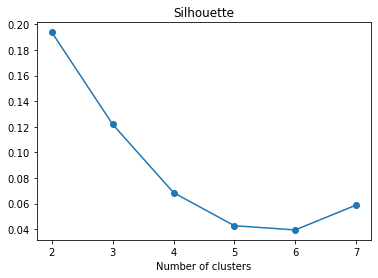

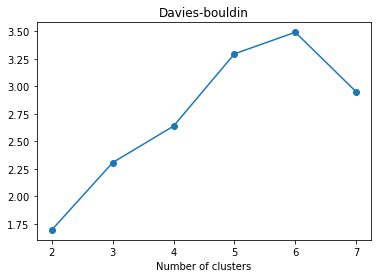

In [76]:

plt.plot(range(2, max_n_clusters, 1), sil_list, marker='o')
plt.title("Silhouette")
plt.xlabel("Number of clusters")
plt.show()

plt.plot(range(2, max_n_clusters, 1), dbi_list, marker='o')
plt.title("Davies-bouldin")
plt.xlabel("Number of clusters")
plt.show()



In [128]:
initial_medoids = kmeans_plusplus_initializer(x, 2).initialize(return_index=True)
kmedoids_instance = kmedoids(x, initial_medoids, metric=metric)
kmedoids_instance.process()
assignment = kmedoids_instance.predict(x)

In [129]:
df_x["assignment"] = assignment
df_x[df_x["assignment"]==0]


,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,gender_unknown,gender_Male,...,major_discipline_No Major,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup,assignment
0,0.657186,0,0,1.0,0,0,0,-0.822220,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0.657186,0,0,2.0,0,0,0,-0.688898,0,1,...,0,0,1,0,0,0,0,0,0,0
3,0.657186,0,0,1.0,0,0,1,-0.505581,0,1,...,0,0,1,0,0,0,0,0,0,0
4,-2.225316,1,2,2.0,0,0,1,-0.372259,0,1,...,0,0,1,0,0,0,0,0,0,0
8,-2.777457,1,0,3.0,3,0,1,-0.222272,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,-1.665055,0,2,3.0,0,0,1,-0.838885,1,0,...,0,0,1,0,0,0,0,0,0,0
15319,-2.265914,1,0,2.0,0,0,1,1.594238,1,0,...,0,0,1,0,0,0,0,0,0,0
15321,0.738384,0,0,2.0,3,0,5,-0.672233,1,0,...,0,0,1,0,0,0,0,0,0,0
15322,0.299919,0,2,1.0,0,0,0,0.944294,0,1,...,0,0,1,0,0,0,0,0,0,0


In [131]:
df_x[df_x["assignment"]==1]


,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,gender_unknown,gender_Male,...,major_discipline_No Major,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup,assignment
1,0.551630,1,0,3.0,1,6,1,3.277426,0,1,...,0,0,0,1,0,0,0,0,0,1
5,0.551630,1,0,3.0,3,5,2,-0.788890,0,1,...,0,0,0,1,0,0,0,0,0,1
6,0.738384,1,0,2.0,1,1,2,-0.605572,0,1,...,0,0,0,1,0,0,0,0,0,1
7,-1.064195,1,0,3.0,2,3,5,0.944294,0,1,...,0,0,0,1,0,0,0,0,0,1
11,0.535391,1,0,3.0,3,8,5,-0.588907,0,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15317,0.738384,1,0,2.0,3,8,5,0.544329,0,1,...,0,0,0,1,0,0,0,0,0,1
15318,-1.665055,1,0,2.0,0,8,2,-0.338928,0,1,...,0,0,0,1,0,0,0,0,0,1
15320,0.738384,1,0,2.0,3,8,2,-0.905546,0,1,...,0,0,0,1,0,0,0,0,0,1
15323,0.519151,1,0,3.0,2,2,2,-0.138946,0,1,...,0,0,0,0,0,0,0,1,0,1


In [132]:
y = df_y.to_numpy()

In [134]:
df_x["target"] = y

In [135]:
df_x

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,gender_unknown,gender_Male,...,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup,assignment,target
0,0.657186,0,0,1.0,0,0,0,-0.822220,1,0,...,0,1,0,0,0,0,0,0,0,1
1,0.551630,1,0,3.0,1,6,1,3.277426,0,1,...,0,0,1,0,0,0,0,0,1,0
2,0.657186,0,0,2.0,0,0,0,-0.688898,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0.657186,0,0,1.0,0,0,1,-0.505581,0,1,...,0,1,0,0,0,0,0,0,0,0
4,-2.225316,1,2,2.0,0,0,1,-0.372259,0,1,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15321,0.738384,0,0,2.0,3,0,5,-0.672233,1,0,...,0,1,0,0,0,0,0,0,0,1
15322,0.299919,0,2,1.0,0,0,0,0.944294,0,1,...,0,1,0,0,0,0,0,0,0,0
15323,0.519151,1,0,3.0,2,2,2,-0.138946,0,1,...,0,0,0,0,0,0,1,0,1,1
15324,-1.665055,0,2,2.0,0,0,0,-0.822220,1,0,...,0,1,0,0,0,0,0,0,0,0


## SVM - Linear Support Vector Classification

In [280]:
from sklearn.svm import LinearSVC

# Training the Baseline model
model = LinearSVC(C=1,max_iter = 2000,random_state = 77)
model.fit(X_train, y_train)


LinearSVC(C=1, max_iter=2000, random_state=77)

In [281]:
model.predict(X_train)

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

In [282]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

print(confusion_matrix(y_true=y_train, y_pred=model.predict(X_train)))
print("Roc_Auc_Score on Training Set:",roc_auc_score(y_train, model.predict(X_train)))
print("Roc_Auc_Score on Test Set:",roc_auc_score(y_test, model.predict(X_test)))
model.coef_

[[8460  728]
 [1932 1140]]
Roc_Auc_Score on Training Set: 0.6459299834022638
Roc_Auc_Score on Test Set: 0.6245136186770427


array([[ 2.14245729,  0.30085273,  0.00315292, -0.02816387,  0.13943495,
         0.35941816, -0.78010808, -0.12565106, -0.1923996 ,  1.33569821,
         0.13092637, -0.13632918]])

In [174]:
df_x.head()

,city,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours,gender_unknown,...,major_discipline_Humanities,major_discipline_No Major,major_discipline_Business Degree,company_type_unknown,company_type_Pvt Ltd,company_type_Public Sector,company_type_NGO,company_type_Other,company_type_Early Stage Startup,company_type_Funded Startup
0,0.115942,0.958904,0,0,1.0,0.095238,0,0,0.047619,1,...,0,0,0,1,0,0,0,0,0,0
1,0.109937,0.945205,1,0,3.0,0.285714,6,1,0.779762,0,...,0,0,0,0,1,0,0,0,0,0
2,0.115942,0.958904,0,0,2.0,0.142857,0,0,0.071429,0,...,0,0,0,1,0,0,0,0,0,0
3,0.115942,0.958904,0,0,1.0,0.142857,0,1,0.104167,0,...,0,0,0,1,0,0,0,0,0,0
4,0.586957,0.584826,1,2,2.0,0.190476,0,1,0.127976,0,...,0,0,0,1,0,0,0,0,0,0


## Hyperparameter Tuning - GridSearch - SVM

In [254]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10,50, 100,200,500, 1000]
             }
GS = GridSearchCV(estimator=LinearSVC(random_state = 77,max_iter=2000),param_grid = param_grid)
GS.fit(X_train,y_train)
GS.best_estimator_


C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

LinearSVC(C=10, max_iter=2000, random_state=77)

In [255]:
best_model = GS.best_estimator_
# print (best_model.best_score_, best_model.best_params_) 
prediction = best_model.predict(X_test)
print("Best Roc_Auc_Score on Cross-Validation Set:",round(GS.best_score_, 3))
print("Best Parameters: " ,GS.best_params_)
print("Roc_Auc_Score on Training Set:", round(roc_auc_score(y_train, best_model.predict(X_train)),3))
print("Roc_Auc_Score on Test Set:", round(roc_auc_score(y_test, prediction),3))
print(confusion_matrix(y_true=y_test, y_pred=model.predict(X_test)))
best_model.coef_

Best Roc_Auc_Score on Cross-Validation Set: 0.784
Best Parameters:  {'C': 10}
Roc_Auc_Score on Training Set: 0.639
Roc_Auc_Score on Test Set: 0.611
[[2121  192]
 [ 504  249]]


array([[ 2.19285062,  0.3399907 , -0.01422526,  0.0690639 ,  0.0824846 ,
        -0.13306614, -0.03589766,  0.02320092, -0.13754013, -0.25996785,
        -0.2507175 , -0.23520459, -0.15181443, -0.19050114, -0.17870619,
        -0.19724403, -0.11481625, -0.11575234, -0.10068442,  0.07750606,
        -0.15564858, -0.11571508, -0.13971099, -0.03761342, -0.25886236,
        -0.26765999]])

In [256]:
results = pd.DataFrame([[GS.best_params_,round(roc_auc_score(y_test, prediction),3),round(roc_auc_score(y_train, best_model.predict(X_train)),3)]],columns = ['parameter','val_acc','train_a'])
results.head()

,parameter,val_acc,train_a
0,{'C': 10},0.611,0.639


In [142]:
df_x.head()

,city_development_index,gender_Other,major_discipline_Arts,company_type_Other,company_type_Funded Startup
0,0.657186,0,0,0,0
1,0.551630,0,0,0,0
2,0.657186,0,0,0,0
3,0.657186,0,0,0,0
4,-2.225316,0,0,0,0


## DecisionTreeClassifier

In [283]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import cross_val_score

In [284]:
from sklearn.model_selection import train_test_split # Import train_test_split function
# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42) # 80% training and 20% test

In [285]:
# How Train and Test are splitted

print("Train\n-----------\n", pd.value_counts(y_train)/y_train.shape[0])
print("\nTest\n-----------\n", pd.value_counts(y_test)/y_test.shape[0])

Train
-----------
 0    0.749429
1    0.250571
Name: target, dtype: float64

Test
-----------
 0    0.754403
1    0.245597
Name: target, dtype: float64


In [286]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Training the Baseline model
model = DecisionTreeClassifier(random_state=77)
model.fit(X_train, y_train)
print("Roc_Auc_Score on Training Set:",roc_auc_score(y_train, model.predict(X_train)))
print("Roc_Auc_Score on Test Set:",roc_auc_score(y_test, model.predict(X_test)))


Roc_Auc_Score on Training Set: 0.9977213541666667
Roc_Auc_Score on Test Set: 0.6293976708815409


## Hyperparameter Tuning - GridSearch - DecisionTreeClassifier

In [287]:
from sklearn.model_selection import GridSearchCV

parameters_grid = {'max_depth': np.arange(1, 20, 1),
                   'criterion': ['entropy', 'gini'],
                   'min_samples_split': np.arange(2,200,20),
                   
             }

GS = GridSearchCV(estimator= DecisionTreeClassifier(random_state=77),
                  scoring = 'roc_auc',
                  param_grid=parameters_grid,
                  cv = 10,
                  return_train_score = True,
                  refit = 'roc_auc')
GS.fit(X_train, y_train)
best_model = GS.best_estimator_
# print (best_model.best_score_, best_model.best_params_) 
prediction = best_model.predict(X_test)
print("Best Roc_Auc_Score on Cross-Validation Set:",round(GS.best_score_, 3))
print("Best Parameters: " ,GS.best_params_)
print("Roc_Auc_Score on Test Set:", round(roc_auc_score(y_test, prediction),3))




Best Roc_Auc_Score on Cross-Validation Set: 0.804
Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 162}
Roc_Auc_Score on Test Set: 0.704


In [291]:
best_model.feature_importances_

array([0.62385761, 0.00343069, 0.        , 0.02322539, 0.00737168,
       0.0557204 , 0.00146639, 0.01198792, 0.22377505, 0.01981421,
       0.02213209, 0.00721856])

In [292]:
df_x.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.115942,0.910,0.310250,0,0.0,0.25,0.251643,0.095238,0.00,0.386405,0.0,0.044776
1,0.109937,0.897,0.227299,1,0.0,0.75,0.251643,0.285714,0.75,0.182893,0.2,0.779104
2,0.115942,0.910,0.227299,0,0.0,0.50,0.251643,0.142857,0.00,0.386405,0.0,0.068657
3,0.115942,0.910,0.227299,0,0.0,0.25,0.251643,0.142857,0.00,0.386405,0.2,0.101493
4,0.586957,0.555,0.227299,1,1.0,0.50,0.251643,0.190476,0.00,0.386405,0.2,0.125373


In [170]:
from sklearn.model_selection import RandomizedSearchCV

RS = RandomizedSearchCV(estimator= DecisionTreeClassifier(random_state=77),
                  scoring = 'roc_auc',
                  param_distributions=parameters_grid,
                  cv = 10,
                  return_train_score = True,
                  refit = 'roc_auc',
                       n_iter=300,random_state=123)
RS.fit(X_train, y_train)
best_model_RS = RS.best_estimator_
# print (best_model.best_score_, best_model.best_params_) 
prediction_RS = best_model_RS.predict(X_test)
print("Best Roc_Auc_Score on Cross-Validation Set:",round(RS.best_score_, 3))
print("Best Parameters: " ,RS.best_params_)
print("Roc_Auc_Score on Test Set:", round(roc_auc_score(y_test, prediction_RS),3))

Best Roc_Auc_Score on Cross-Validation Set: 0.803
Best Parameters:  {'min_samples_split': 182, 'max_depth': 8, 'criterion': 'entropy'}
Roc_Auc_Score on Test Set: 0.715


In [181]:
print("Roc_Auc_Score on Training Set:",roc_auc_score(y_train, best_model.predict(X_train)))


Roc_Auc_Score on Training Set: 0.6690206343645698


In [40]:
### Save best parameters of Grid Search

#   Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 18}

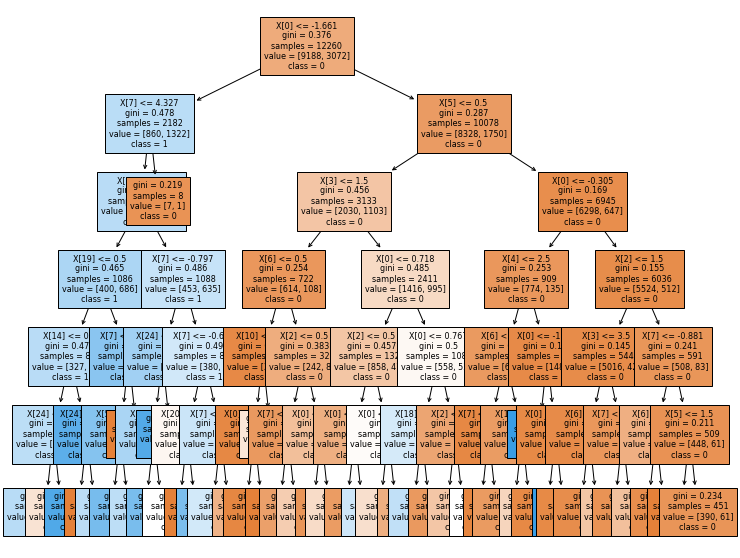

In [41]:
plt.figure(figsize=(12, 10))
plot_tree(best_model, filled=True, class_names=['0', '1'],fontsize = 8)
plt.show()

C:\Users\peleg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\peleg\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


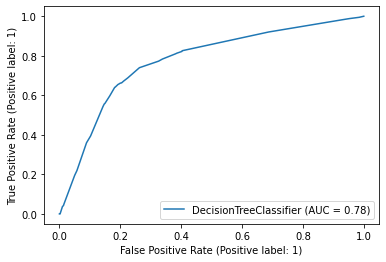

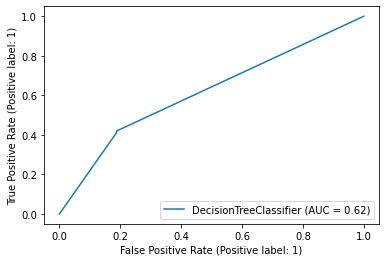

In [42]:
metrics.plot_roc_curve(best_model, X_test, y_test)
metrics.plot_roc_curve(model, X_test, y_test)


## Experience - Continuous Variable

In [ ]:
df["experience"] = df["experience"].replace("<1","0")
df["experience"] = df["experience"].replace(">20","21")
df["experience"] = pd.to_numeric(df["experience"])
df["experience"] = df["experience"].fillna(0)
print(df["experience"].value_counts())


In [137]:
max = df["city_development_index"].max()
df["city_development_index"] = df["city_development_index"]/max

0.9738556260708614
